In [1]:
%matplotlib widget

import wave
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as signal
from scipy.fft import fftshift

### Summary

This book loads in a WAV file, will plot the channel time data and spectra. It then plots spectrograms for each channel.

The plots are interactive - viewing them in a booklet will allow one to zoom in and play around with the data

In [19]:

def ReadInWAVFile(file_path):
    """Reads on a WAV file

    Args:
        file_path (String): Absolute path the WAV file

    Returns:
        channel_data (Arr): Channel data
        sample_rate (Int)" Sample rate of recording
        num_channels (Int): Number of channels in recording
    """
    # Separate channels into individual arrays
    channel_data = []
    sample_rate = -1
    num_channels = -1

    # Open the WAV file
    with wave.open(file_path, 'rb') as wav_file:
        num_channels = wav_file.getnchannels()
        num_frames = wav_file.getnframes()
        sample_rate = wav_file.getframerate()

        # Read audio frames from the WAV file
        frames = wav_file.readframes(num_frames)

        # Convert the binary data to a NumPy array
        audio_data = np.frombuffer(frames, dtype=np.int16)
    
        for i in range(num_channels):
            channel = audio_data[i::num_channels]
            channel_data.append(channel)

    return channel_data, sample_rate, num_channels


# Replace 'your_file_path.wav' with the path to your WAV file
# PoolTests2 HarbourTest
fileName = "Audio_fs_44100_Chans_4_1704987652_Docked" +'.wav'
file_path = 'D:\\Recordings_All\\SailingTests\\'
 
# Separate channels into individual arrays
channel_data, sample_rate, num_channels = ReadInWAVFile(file_path + fileName)

print("Channel count (n): " + str(num_channels))
print("Sample rate (Hz): " + str(sample_rate))
recording_length = str(len(channel_data[0])* 1/sample_rate)
print("Recording length (s): " + recording_length)

Channel count (n): 4
Sample rate (Hz): 44100
Recording length (s): 30.00018140589569


### Time and Freq Plot

In [34]:
# Plot each channel
period_to_plot = 1 # seconds
averaging_count = 30
channel_of_interest = 3

sample_count = int(period_to_plot*sample_rate)
frequecy_band_of_interest = 1000

# Create a low-pass Butterworth filter
cutoff_frequency = 10  # Adjust this cutoff frequency as needed (Hz)
order = 4  # Filter order

spectrogram_samples_per_segment = 44100

# Turn on interactive mode
if True:

    plt.ion()

    fig, ax = plt.subplots(2,1, figsize=(30, 15))
    time_axis = np.linspace(0,1,sample_count)
    freq_axis = np.linspace(0,sample_count,sample_count)* (sample_rate/sample_count) - sample_rate/2
    frequency_index_bound = int(frequecy_band_of_interest/(sample_rate/sample_count)) 
    plt.suptitle(f'Analysis of {fileName} With Sample Rate {sample_rate} and recording length of {int(float(recording_length))} seconds')

    # Time domain plot
    for i, channel in enumerate(channel_data):
        ax[0].plot(time_axis, channel[:sample_count], label=f'Channel {i + 1} FFT')

    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Amplitude (Arb)')
    ax[0].set_title('Audio Channels (n)')
    ax[0].legend()


    # FFT and FFT Subset plot
    centre_freq_index = int(len(freq_axis)/2)
    bound_space = 250
    upper_bound = centre_freq_index + frequency_index_bound
    lower_bound = centre_freq_index - frequency_index_bound
    

    # Incoherent gain
    for i, channel in enumerate(channel_data):
        
        averaged_fft_data = np.zeros((sample_count))

        for j in range(averaging_count):
            fft_data_tmp = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(channel[j*sample_count:(j+1)*sample_count])))/sample_count)
            averaged_fft_data += fft_data_tmp
        
        ax[1].plot(freq_axis, averaged_fft_data/averaging_count, label=f'Channel {i + 1}')

    ax[1].set_title(f'Audio Channel {channel_of_interest + 1} - Amplitude Averaging of {averaging_count}')
    ax[1].set_xlabel('Freq (Hz)')
    ax[1].set_xscale('log')
    ax[1].set_ylabel('Amplitude (Arb_dB)')

    plt.show()


SyntaxError: f-string: closing parenthesis '}' does not match opening parenthesis '(' (3749549492.py, line 24)

### Spectrogram Plot

#### Amplitude Data

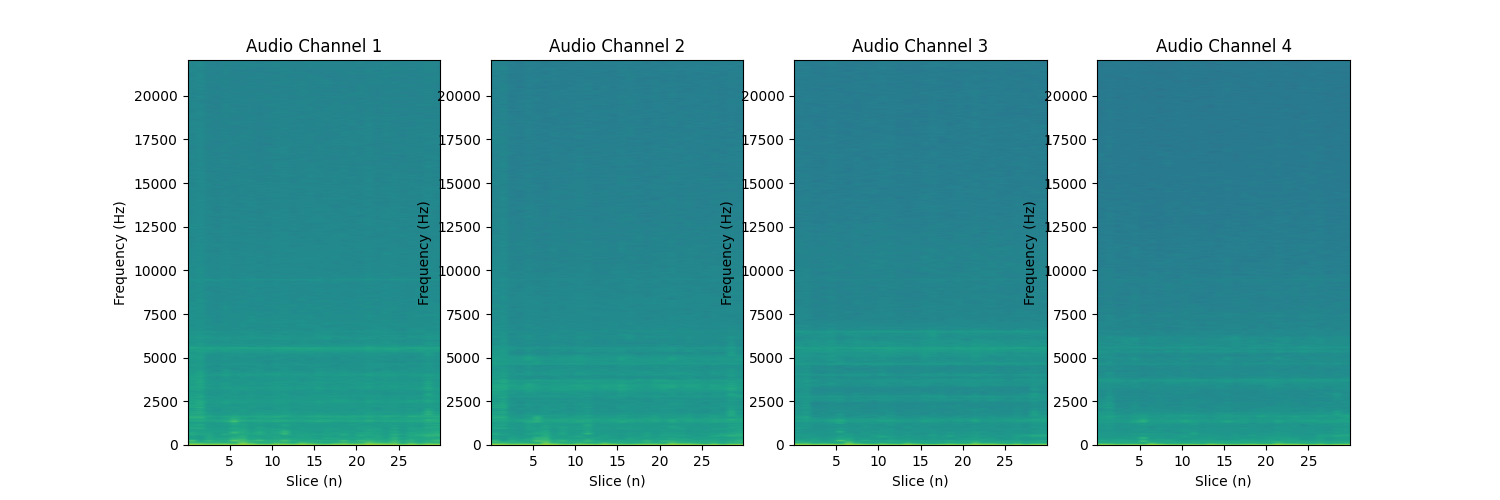

In [36]:
if True:
    
    plt.ion()
    fig1, ax = plt.subplots(1,num_channels, figsize=(15, 5))
    fft_size = 44100

    for i, channel in enumerate(channel_data):
        ax[i].specgram(channel,Fs=sample_rate,NFFT=fft_size)
        ax[i].set_ylabel('Frequency (Hz)')
        ax[i].set_xlabel('Slice (n)')
        ax[i].set_title(f'Audio Channel {i + 1}')

        f_Sxx1, t_Sxx1, Sxx1 = signal.spectrogram(channel, fs=sample_rate,  nperseg=fft_size)


    plt.show()

### Incoherent Gain Check

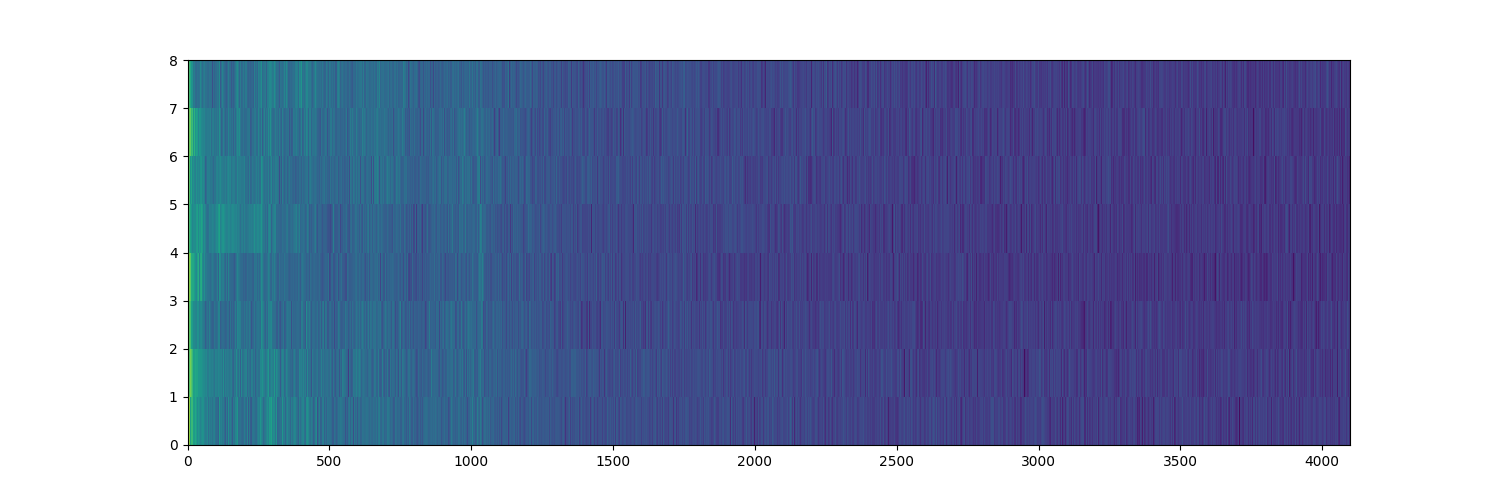

In [37]:
if True:
    
    plt.ion()
    fig, ax = plt.subplots(1, figsize=(15, 5))

    fft_size = 8196
    averaging_factor = 20
    spectrogram_samples = int(len(channel_data[2])/(fft_size*averaging_factor))

    pilot_spectrogram_data = np.empty((spectrogram_samples,fft_size), dtype=np.complex128)

    for i in range(spectrogram_samples):
         
         tmp2 = np.zeros((fft_size), dtype=np.complex128)

         for k in range(averaging_factor):
         
               tmp = np.zeros((fft_size), dtype=np.complex128)

               for j in range(num_channels):
                    tmp += np.abs(np.fft.fft(channel_data[j][i*fft_size: (i+1)*fft_size]))

               tmp2  += np.abs(tmp)    

         pilot_spectrogram_data[i,:] = tmp2
         
    ax.pcolormesh(20*np.log10(np.abs(pilot_spectrogram_data[:, :int(fft_size/2)])))
    plt.show()


#### Channel Phase Analysis

Differential phase between channel 1 and 2

Frequency of interest 2000 at index 2000


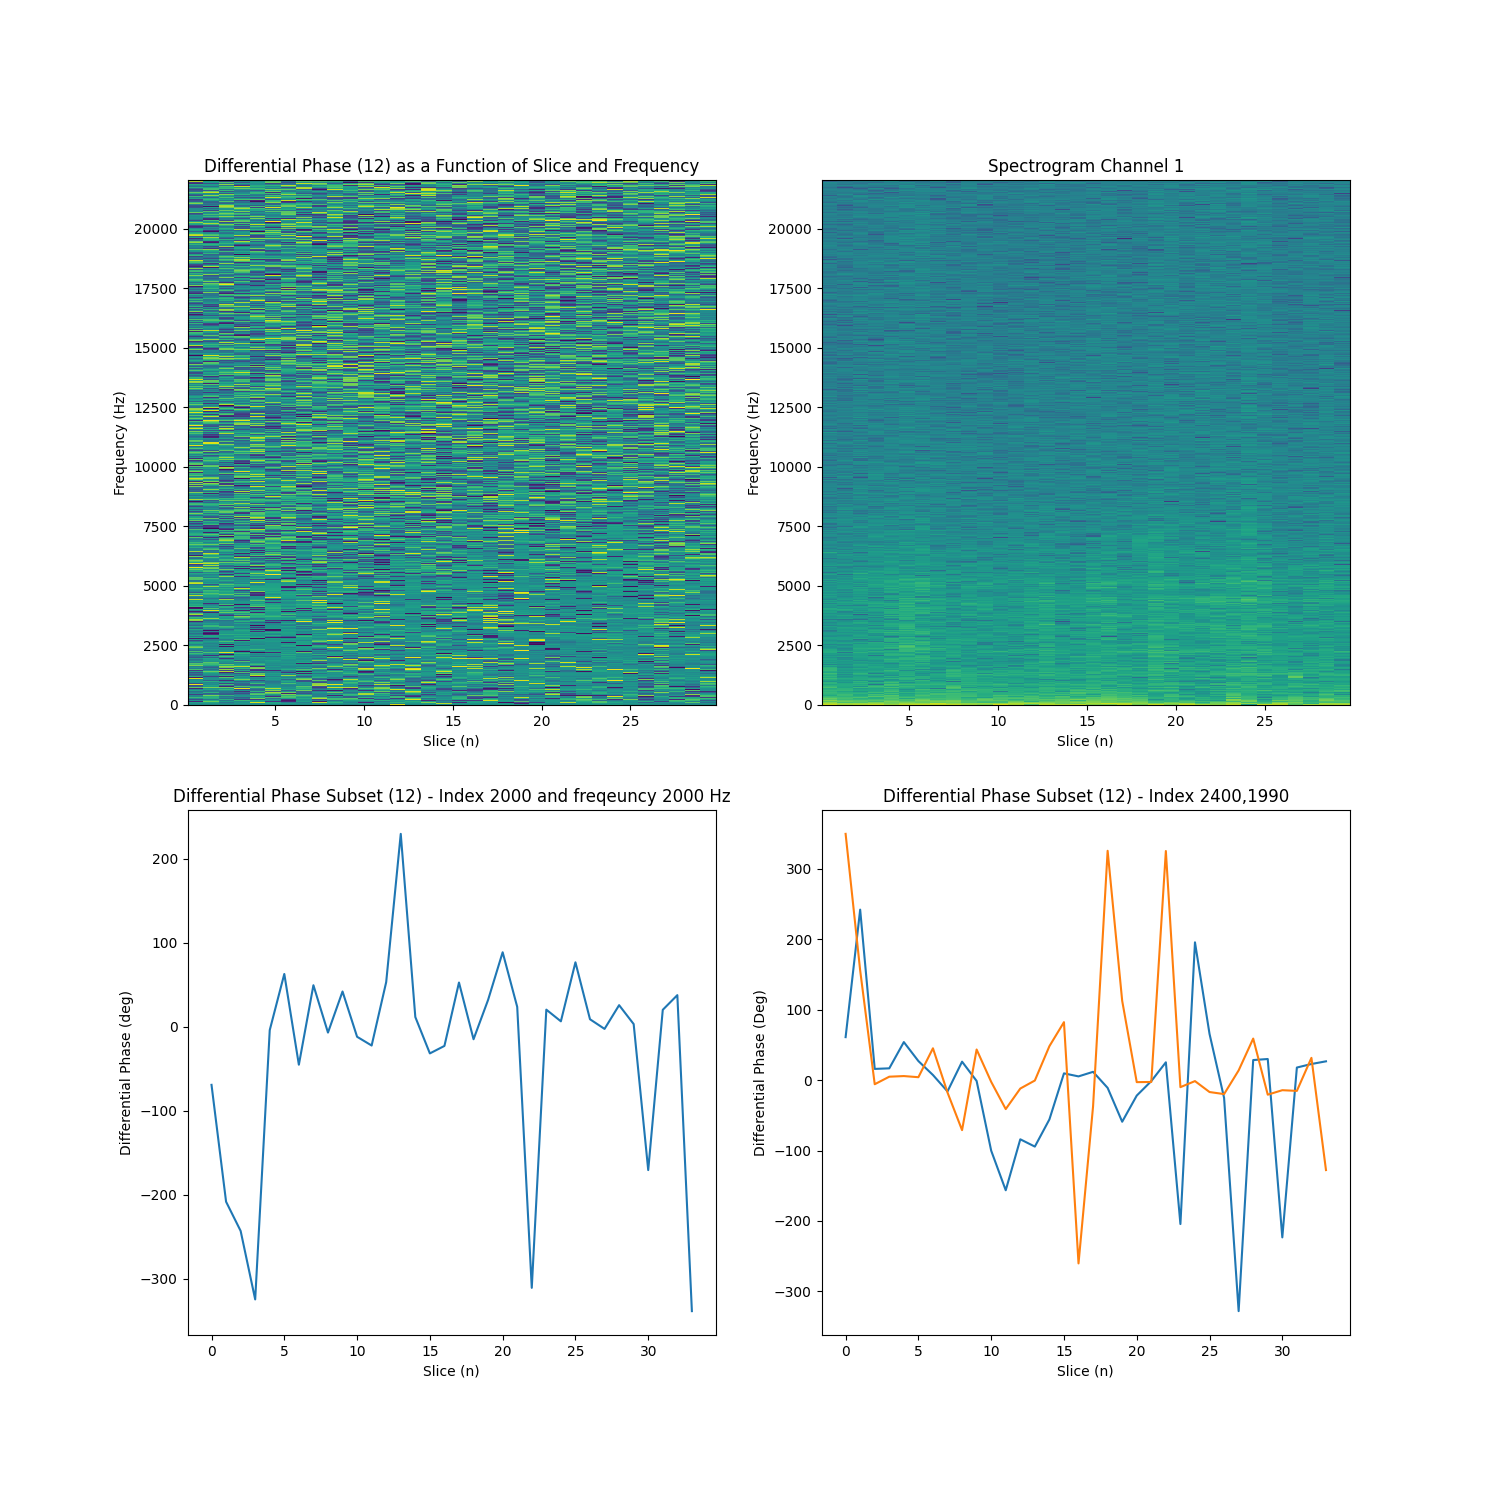

In [20]:
if True:
    
    # Calculate the spectrogram for both channels
    nperseg = 44100
    frequecy_of_interest = 2000 # Hz0
    index_of_interest = int(frequecy_of_interest/(sample_rate/nperseg)) 
    print(f'Frequency of interest {frequecy_of_interest} at index {index_of_interest}')
          
    plt.clf()
    plt.ion()
    fig, ax = plt.subplots(2,2, figsize=(15, 15))

   
    f_Sxx1, t_Sxx1, Sxx1 = signal.spectrogram(channel_data[0], fs=sample_rate,  nperseg=nperseg)
    f_Axx1, t_Axx1, Axx1 = signal.spectrogram(channel_data[0], fs=sample_rate, nperseg=nperseg,mode='angle')
    f_Axx2, t_Axx2, Axx2 = signal.spectrogram(channel_data[1], fs=sample_rate, nperseg=nperseg,mode='angle')

    ax[0,0].pcolormesh(t_Sxx1, f_Sxx1, Axx1-Axx2)
    ax[0,0].set_title('Differential Phase (12) as a Function of Slice and Frequency')
    ax[0,0].set_xlabel('Slice (n)')
    ax[0,0].set_ylabel('Frequency (Hz)')

    ax[0,1].pcolormesh(t_Axx1, f_Axx1 ,20*np.log10(Sxx1))
    ax[0,1].set_title('Spectrogram Channel 1')
    ax[0,1].set_xlabel('Slice (n)')
    ax[0,1].set_ylabel('Frequency (Hz)')

    ax[1,0].plot(np.squeeze((Axx1-Axx2)[index_of_interest,:])*180/np.pi) 
    ax[1,0].set_xlabel('Slice (n)')
    ax[1,0].set_ylabel('Differential Phase (deg)')
    ax[1,0].set_title(f'Differential Phase Subset (12) - Index {index_of_interest} and freqeuncy {frequecy_of_interest} Hz')  

    ax[1,1].plot(np.squeeze((Axx1-Axx2)[index_of_interest-10,:])*180/np.pi) 
    ax[1,1].plot(np.squeeze((Axx1-Axx2)[index_of_interest+400,:])*180/np.pi) 
    ax[1,1].set_xlabel('Slice (n)')
    ax[1,1].set_ylabel('Differential Phase (Deg)')
    ax[1,1].set_title(f'Differential Phase Subset (12) - Index {index_of_interest+400},{index_of_interest-10}')

    plt.show()